In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import textwrap
from umap import UMAP
import datapane as dp
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
import scikitplot as skplt
from tqdm import tqdm

sns.set_style('whitegrid')
%matplotlib inline

from custom_functions import *

tqdm.pandas()

C:\Users\adshafi\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub

C:\Users\adshafi\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
X_train = pd.read_pickle('./pickled_data/X_train.pkl')
X_test = pd.read_pickle('./pickled_data/X_test.pkl')
y_train = pd.read_pickle('./pickled_data/y_train.pkl')
y_test = pd.read_pickle('./pickled_data/y_test.pkl')

In [4]:
### Pretrained BERT does handle words it hasn't seen before by splitting them up. However unless we train the model it won't understand our tags.

X_train['text'] = (X_train['text']
                    .str.replace('\n',' ', regex=False)
                    .str.replace('[AT_USER]','@', regex=False)
                    .str.replace('[URL]','url', regex=False)
                    .str.strip())


X_test['text'] = (X_test['text']
                    .str.replace('\n',' ', regex=False)
                    .str.replace('[AT_USER]','@', regex=False)
                    .str.replace('[URL]','url', regex=False)
                    .str.strip())

### Universal Sentence Encoder

Publishing report and associated data - please wait..


C:\Users\adshafi\Anaconda3\lib\site-packages\datapane\client\api\report\core.py:249: UserWarning:

Passing visibility as a string is deprecated, use dp.Visibility enum instead.



Report successfully published at https://datapane.com/u/adam1/reports/universal-sentence-encoder-vectors/
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/adam1/reports/universal-sentence-encoder-model/


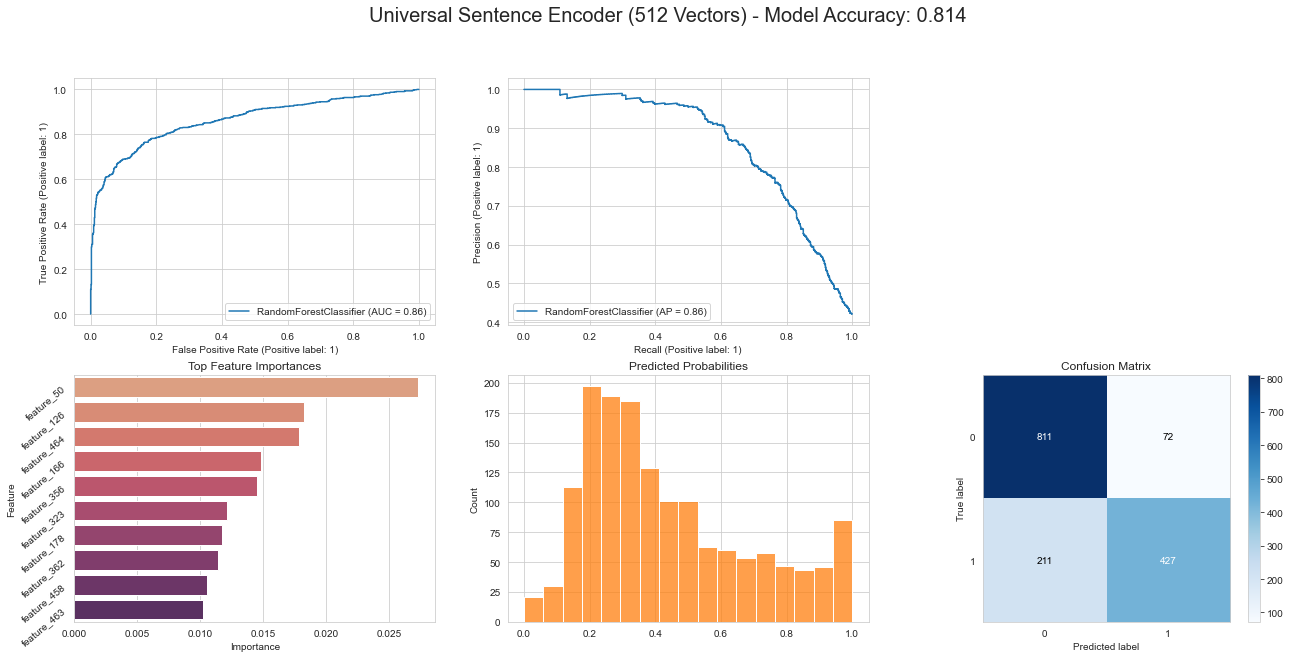

In [5]:
def embed_document(data):
    model = hub.load("../USE/")
    embeddings = np.array([np.array(model([i])) for i in data])
    return pd.DataFrame(np.vstack(embeddings)) 

# vectorize the data

X_train_vec = embed_document(X_train['text'])
X_test_vec = embed_document(X_test['text'])

cols = [f'feature_{i}' for i in range(X_train_vec.shape[1])] # USE doesn't have feature names

# to get a dataframe

X_train_df = pd.DataFrame(X_train_vec)
X_train_df.columns = cols

# fit a random forest model

model = RandomForestClassifier(n_estimators=500, n_jobs=8)
model.fit(X_train_vec,y_train)
model_plot = model_summary_plot(model, X_test_vec, y_test, cols,
                                f'Universal Sentence Encoder ({X_train_df.shape[1]} Vectors)',
                                model.feature_importances_,n=10)


dp_publish(umap_plot(X_train, y_train, X_train_df),'Universal Sentence Encoder Vectors')

dp_publish(model_plot,'Universal Sentence Encoder Model')

### BERT

100%|██████████| 1521/1521 [05:38<00:00,  4.50it/s]


Publishing report and associated data - please wait..


C:\Users\adshafi\Anaconda3\lib\site-packages\datapane\client\api\report\core.py:249: UserWarning:

Passing visibility as a string is deprecated, use dp.Visibility enum instead.



Report successfully published at https://datapane.com/u/adam1/reports/bert-vectors/
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/adam1/reports/bert-model/


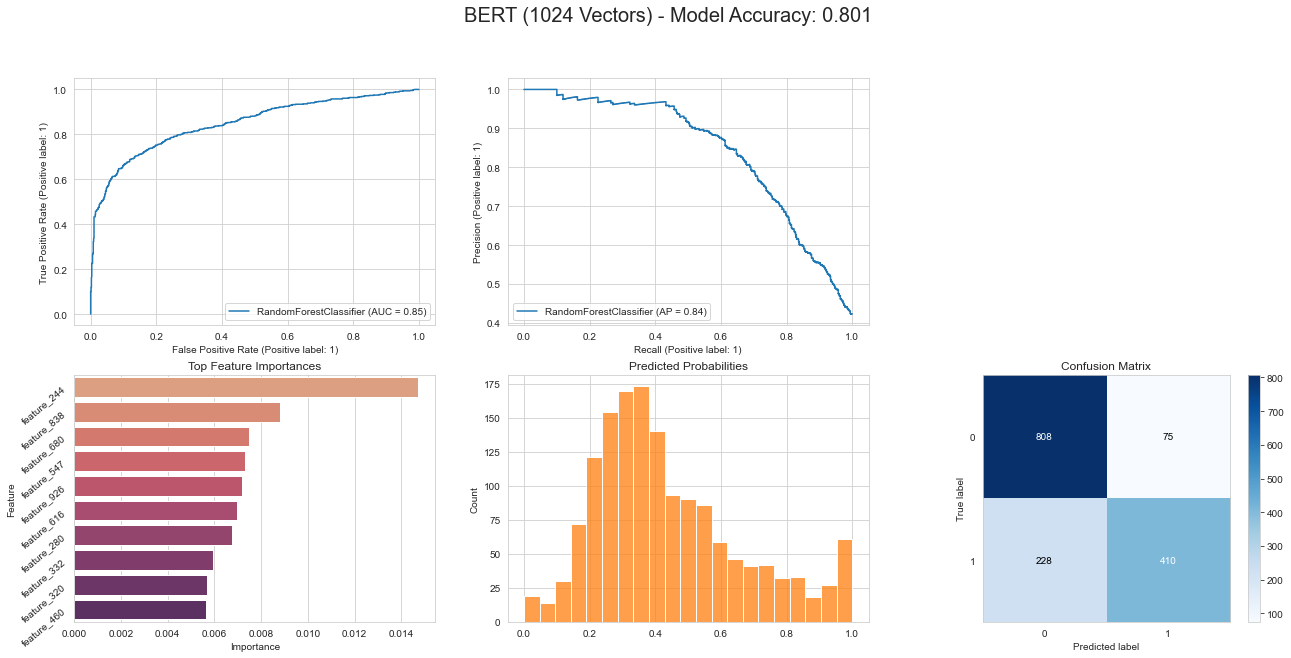

In [6]:
### Download the model 
bert = SentenceTransformer('stsb-roberta-large')

# vectorize the data

X_train_vec = pd.DataFrame(np.vstack(X_train['text'].progress_apply(bert.encode)))
X_test_vec = pd.DataFrame(np.vstack(X_test['text'].progress_apply(bert.encode)))

X_train_vec.to_pickle('X_train_bert.pkl')
X_test_vec.to_pickle('X_test_bert.pkl')

cols = [f'feature_{i}' for i in range(X_train_vec.shape[1])] # BERT doesn't have feature names

# to get a dataframe

X_train_df = pd.DataFrame(X_train_vec)
X_train_df.columns = cols

# fit a random forest model

model = RandomForestClassifier(n_estimators=500, n_jobs=8)
model.fit(X_train_vec,y_train)
model_plot = model_summary_plot(model, X_test_vec, y_test, cols,
                                f'BERT ({X_train_df.shape[1]} Vectors)',
                                model.feature_importances_,n=10)


dp_publish(umap_plot(X_train, y_train, X_train_df),'BERT Vectors')

dp_publish(model_plot,'BERT Model')